We perform demand predictions for __SKU configs within groups__ (determined by [sub-category, gender, season], e.g., [shirts, male, spring-summer] is a group). We currently have 700+ such groups in our data. However, 25% of groups have less than 5 configs, too few data, and half of them have less than 20 configs (see stats + histogram). Thus, we will first look at the more interesting upper half of groups, where each group has at least 20 configs.

In [1]:
# load std modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import xgboost as xgb
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from matplotlib.pyplot import Line2D

In [2]:
# various dirs
DAT_DIR = '/Users/gfg/data/venture=Zalora/sg/'
CLEAN_DIR = DAT_DIR + 'clean/'; FIG_DIR = DAT_DIR + 'fig/'
GROUP_DIR = CLEAN_DIR + 'groups/'; FEAT_DIR = GROUP_DIR + 'feats/'

### Distribution of group sizes

In [19]:
def size_hist(group_df):
    pl.figure(figsize = (10, 5))
    pl.hist(group_df['n_config'], bins=50)
    ax = pl.gca()
    ax.minorticks_on()
    pl.xlabel('# configs in group'); pl.ylabel('# groups')
    pl.grid(True, ls='--')
    pl.savefig(FIG_DIR + 'group_size_hist.pdf')
    pl.show(); pl.close()

In [20]:
group_df = pd.read_csv(CLEAN_DIR + 'groups.csv')
group_df.n_config.describe()

count     724.000000
mean      103.056630
std       272.492442
min         1.000000
25%         4.000000
50%        19.000000
75%        86.000000
max      3305.000000
Name: n_config, dtype: float64

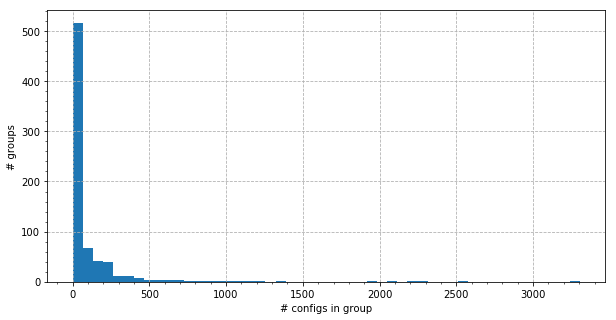

In [21]:
size_hist(group_df)

Each group is associated with one feature matrix, which is composed from __global__ features (e.g. color/size/brand popularities) and __group__ features (e.g. price, discount, relative price,...).

# Loading data

## Responses

In [3]:
demand_df = pd.read_csv(CLEAN_DIR + 'demand_config.csv', parse_dates=['ordered_date'])
demand_df['date'] = demand_df['ordered_date']

## Global feats

In [4]:
def load_global_feat(yr):
    fname = CLEAN_DIR + '{}/'.format(yr) + 'glob_feat.csv'
    print('Loading global feature matrix in year {0} from {1}...'.format(yr, fname))
    glob_X = pd.read_csv(fname, parse_dates=['date'])
    return glob_X

In [51]:
yr=2017
glob_X = load_global_feat(yr)
print('Info on global feature matrix in year {}:'.format(yr))
glob_X.info()

Loading global feature matrix in year 2017 from /Users/gfg/data/venture=Zalora/sg/clean/2017/glob_feat.csv...


NameError: name 'yr' is not defined

## Time-based features

In [34]:
# weekend vs. weekday, weekend are 5 (Sat) and 6 (Sun)
def is_weekend(day_code):
    return 1 if day_code in [5, 6] else 0

def is_workday(day_code):
    return 1 if day_code not in [5, 6] else 0

def add_is_weekend(df):
    res = df.copy()
    res['weekday'] = res['date'].dt.weekday
    res['is_weekend'] = res['weekday'].apply(is_weekend)
    res['is_workday'] = res['weekday'].apply(is_workday)
    return res

## Build ready data for each group

After loading global feats, follow are steps to prepare data for each group.
+ Form feature matrix: by joining group feats with global feats
+ Obtain final ready data: by attaching response to the feature matrix
+ Split training and test sets by date: currently, we are using about $20\%$ of data for testing and all data before that for training.

The methods to perform these steps are defined in section `Helpers` at the beginning of this notebook.

# Helpers

## String utils

In [5]:
def stdize(s):
    return str.lower(s).replace(' ', '_')

## Date-time utils

In [6]:
import date_util

## Data preps

In [7]:
import data_prep
from data_prep import *

## Data splitting

In [8]:
import split
from split import *

In [9]:
def records_by_config(train_df):
    g = train_df.groupby('sku_config')
    size_df = get_group_sizes(g).sort_values('count', ascending=False).rename(columns={'group': 'sku_config'})
    return size_df

+ Try `TimeSeriesSplit` from scikit-learn:

In [8]:
def time_series_split(df):
    tscv = TimeSeriesSplit(n_splits=3)
    for train_index, test_index in tscv.split(df):
        print('train index: {}'.format(train_index))
        print('test index: {}'.format(test_index))

        train_df, test_df = df.iloc[train_index], df.iloc[test_index]
        n_train, n_test = train_df.shape[0], test_df.shape[0]
        print('# obs: {}'.format(n_train + n_test))
        print('Size of train ds: {}'.format(n_train))
        print('Size of test ds: {}'.format(n_test))
        
#     return

# test time series split
time_series_split(prep_data(gname='dresses_female_autumn-winter'))

## Visualization

In [13]:
def init_fig(size=(5, 5), use_avg=False):
    fig = pl.figure(figsize=size)
    ylab = 'Demand' if not use_avg else 'Avg. Demand'
    pl.ylabel(ylab)
    pl.grid(True, ls='--')
    fig.autofmt_xdate()
    return fig

def get_markers(models):
    markers = list(Line2D.markers.keys())
    markers.remove('o')
    return markers[:len(models)]

def do_viz(pred_df, use_avg=False, fig_size=(10, 5)):
    fig = init_fig(fig_size, use_avg)
    dates = pred_df['date']
    y_test = pred_df['n_sold'] if not use_avg else pred_df['avg_n_sold']
    pl.set_cmap('Set1')
    pl.plot(dates, y_test, marker='o', ls='-')
    
    markers = get_markers(models)
    for i in range(len(models)):
        m_name = stdize(model_names[i])
        col = 'predict_{}'.format(m_name) if not use_avg else ('avg_' + 'predict_{}'.format(m_name))
        y_pred = pred_df[col]
        pl.plot(dates, y_pred, marker=markers[i])
    
    pl.legend(['Actual'] + model_names)
    return fig

def viz(predictions, cf, prod_name, fig_size=(10, 5)):
    
    cf_pred = predictions.query('sku_config == "{}"'.format(cf))
    fig = do_viz(cf_pred)
    pl.title('Demand predictions for SKU config: {0} ({1})'.format(cf, prod_name))
    return fig

## Experiments

### Current Features 

In [42]:
feats = ['current_price', 'discount_from_rrp', 'n_competitor', 'rel_price', 'color_pop', 'brand_pop', 
         'is_weekend', 'is_workday']

__Note:__ most features are dynamic, except color/size popularities which are almost static.

### Models and CV Settings

We will compare performance of the following regression models in __demand prediction__ task:

* Lasso: linear with $L_1$ penalty to drive for sparse weights (if we expect them to be sparse, i.e., just few of them are non-zero)
* Bagging Regression Tree (BRT)
* Random Forest
* XGBoost Regressor

### Exp Helpers

In [10]:
def run_exp(gname, feats):
    ready_df = prep_data(gname)
    print()
    
    train_df, test_df = split_train_test(ready_df)
    rmse_df, predictions = fit_predict(models, train_df, test_df)
    return rmse_df, predictions

def cols_to_show(pred):
    pred_cols = [c for c in pred.columns if 'predict_' in c]
    diff_cols = [c for c in pred.columns if 'diff_' in c]
    abs_cols = [c for c in pred.columns if 'abs_' in c]
    cols = ['sku_config', 'product_name', 'brand_name'] + ['n_sold'] + pred_cols + diff_cols + abs_cols
    return cols

def evaluate(predictions, cf='MA193AA06RQJMY', fig_size=(10, 5)):
    
    cf_pred = predictions.query('sku_config == "{}"'.format(cf)).copy()
    
    # diff bw predict and actual
    for m in list(map(stdize, model_names)):
        cf_pred['diff_{}'.format(m)] = cf_pred['predict_{}'.format(m)] - cf_pred['n_sold']
        cf_pred['abs_diff_{}'.format(m)] = np.abs(cf_pred['diff_{}'.format(m)])
        
    
    prod_name = cf_pred['product_name'].iloc[0]
    fig = viz(predictions, cf, prod_name, fig_size)
    return cf_pred, fig

In [11]:
def inspect_results(cf, cols=None):
    cf_pred, fig = evaluate(predictions, cf, fig_size=(16, 8))
    pl.show(); pl.close()
    print()
    print('Samples of prediction:')
    return cf_pred.sort_values('n_sold', ascending=False).head(10) # [cols]

In [12]:
# columns to inspect
rf_cols = ['predict_random_forest', 'diff_random_forest', 'abs_diff_random_forest']
cols = ['sku_config', 'product_name', 'brand_name'] + ['n_sold'] + rf_cols

# Autumn-winter products

## Female dresses

### Example of data prep
Below is an example for illustration purpose. As data preps will be included in benchmark runs, later we do not need to run these steps. 

In [ ]:
ready_df = prep_data(gname='dresses_female_autumn-winter', demand_df=demand_df)

In [36]:
ready_df[['date', 'weekday', 'is_weekend', 'is_workday']].head()

,date,weekday,is_weekend,is_workday
0,2017-06-20,1,0,1
1,2016-04-03,6,1,0
2,2016-04-21,3,0,1
3,2016-12-12,0,0,1
4,2017-01-04,2,0,1


In [37]:
train_df, test_df = split_train_test(ready_df)

Split training and test sets by date 2017-03-28 00:00:00

 # records in training: 10023
Training data span ~11 months

# records in test: 9369
Test data span ~2 months


In [ ]:
# defensive save
folder = GROUP_DIR + 'dresses_female_autumn-winter/'
train_df.to_csv(folder + 'train.csv', index=False)
test_df.to_csv(folder + 'test.csv', index=False)

### Train & Predict

In [61]:
import model_train

In [59]:
reload model_train
from model_train import *

In [60]:
in_loader = InputLoader(DataPrep())
data_splitter = DataSplitter(split_ratio=80)
out_dumper = OutDumper()

2017-11-21 15:33:36 GFG20170005.local root[65694] INFO Loading global feats in yr 2017 from file /Users/gfg/data/venture=zalora/sg/clean/2017/glob_feat.csv...
2017-11-21 15:34:04 GFG20170005.local root[65694] INFO Loading historical sales from /Users/gfg/data/venture=zalora/sg/clean/demand_config.csv...


In [ ]:
model_trainer = ModelTrainer(model_dir=out_dumper.model_dir)
sorted_models = model_trainer.benchmark(group='dresses_female_autumn-winter')
print('Models sorted by test RMSE:')
print(sorted_models)

+ Old code:

In [52]:
train_df, test_df, rmse_df, predictions = benchmark(models, feats, group='dresses_female_autumn-winter')

Preparing data of group dresses_female_autumn-winter...
	 dropped NA configs
Whole data spans from 2017-01-01 to 2017-06-27
Split training and test sets by date 2017-05-21 00:00:00

 # records in training: 13145
Training data span ~4 months

# records in test: 3675
Test data span ~1 months

Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished


0.0171587549786
{'alpha': 0.1}

Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.2min finished


0.0123286742437
{'n_estimators': 10, 'max_depth': 3}

Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.4min finished


0.0143381595488
{'n_estimators': 20, 'max_depth': 3}

Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
0.0174680523776
{'n_estimators': 30, 'max_depth': 3}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   45.6s finished


### Group level evaluations 

#### Avg error of the group

+ RMSE without `is_weekend` and `is_workday`:

In [27]:
rmse_df

,model,test_rmse,train_rmse
0,Lasso Regression,0.975814,1.308303
3,XGBoost,1.035758,1.189273
1,Boosted Regression Tree,1.036121,1.129783
2,Random Forest,1.113883,1.127533


Compared with accuracy of models by DataRobot, ours are a bit worse. It is expected as:
+ we use less features
+ our models are simpler, theirs are much more complicated, for example they blend 5-6 models which are already strong. Basically, theirs are meta/hyper models i.e. models which are combinations of several models.

We can also build meta models ourselves.

#### Actual avg vs. predicted avg

#### Lift charts

In [66]:
predictions.n_sold.describe()

count    9369.000000
mean        1.392465
std         0.976993
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        18.000000
Name: n_sold, dtype: float64

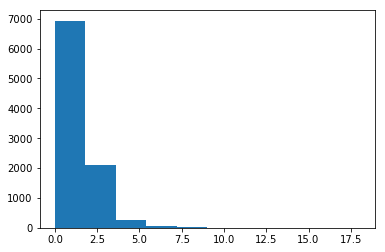

In [67]:
fig = pl.figure()
ns, bins, patches = pl.hist(predictions.n_sold, bins=10)
pl.show(); pl.close()

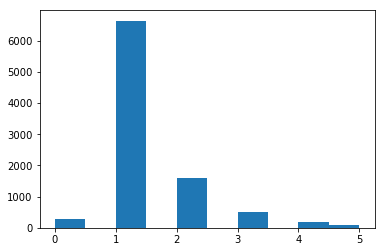

In [70]:
# select only majority demand values
sel_pred = predictions.query('n_sold <= 5')
fig = pl.figure()
ns, bins, patches = pl.hist(sel_pred.n_sold, bins=10)
pl.show(); pl.close()

In [71]:
print('Bin info:')
bin_info = pd.DataFrame({'size': ns, 'lower': bins[0: n_bin], 'upper': bins[1:]})
bin_info

Bin info:


,lower,size,upper
0,0.0,296.0,0.5
1,0.5,0.0,1.0
2,1.0,6635.0,1.5
3,1.5,0.0,2.0
4,2.0,1600.0,2.5
5,2.5,0.0,3.0
6,3.0,493.0,3.5
7,3.5,0.0,4.0
8,4.0,183.0,4.5
9,4.5,82.0,5.0


In [73]:
bin_info = bin_info.query('size > 0')
bin_info.reset_index(inplace=True)
del bin_info['index']
bin_info

,lower,size,upper
0,0.0,296.0,0.5
1,1.0,6635.0,1.5
2,2.0,1600.0,2.5
3,3.0,493.0,3.5
4,4.0,183.0,4.5
5,4.5,82.0,5.0


In [75]:
# calculate avg of actual vs. avg of predictions in each bin
pred_cols = [c for c in predictions.columns if 'predict_' in c]
cols = ['n_sold'] + pred_cols
def avg_in_bin(i, bin_info):
    
    row = bin_info.iloc[i]
    low, high = row['lower'], row['upper']
    sub_df = predictions.query('{} <= n_sold & n_sold < {}'.format(low, high))[cols]
    if sub_df.empty:
        sub_df = predictions.query('{} < n_sold & n_sold <= {}'.format(low, high))[cols]
        
    avg_df = pd.DataFrame(sub_df.apply(np.mean, axis=0))   
    return avg_df.rename(columns={0: 'n_sold in [{}, {}]'.format(low, high)})

In [95]:
n_row = bin_info.shape[0]
frames = [avg_in_bin(i, bin_info) for i in range(n_row)]
pd.concat(frames, 'columns')

,"n_sold in [0.0, 0.5]","n_sold in [1.0, 1.5]","n_sold in [2.0, 2.5]","n_sold in [3.0, 3.5]","n_sold in [4.0, 4.5]","n_sold in [4.5, 5.0]"
n_sold,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
predict_ridge_regression,4.091903,3.282743,2.262004,2.186976,1.663045,1.730837
predict_lasso_regression,1.547973,1.569048,1.651883,1.706530,1.696749,1.743307
predict_boosted_regression_tree,1.440200,1.475622,1.544602,1.632909,1.653365,1.653353
predict_random_forest,1.483370,1.530934,1.602281,1.676320,1.697996,1.677535
predict_xgboost,1.131090,1.158867,1.216333,1.277510,1.269428,1.296537


#### Feature importance

#### Agg by date

In [108]:
target_cols = ['date'] + ['n_sold'] + [c for c in predictions.columns if 'predict_' in c]
daily_pred = predictions[target_cols].groupby('date')

In [111]:
daily_avg = daily_pred.agg(np.mean).add_prefix('avg_').reset_index()
del daily_avg['avg_predict_ridge_regression']

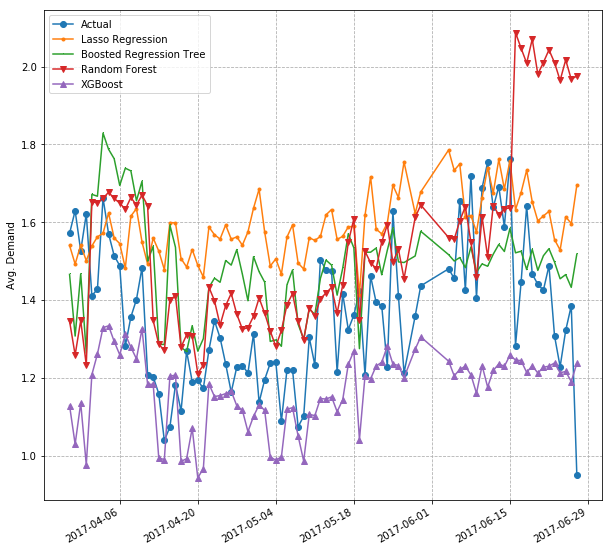

In [118]:
fig = do_viz(daily_avg, use_avg=True, fig_size=(10, 10))
pl.show(); pl.close()

In [166]:
daily_avg.sort_values('avg_predict_lasso_regression', inplace=True)

In [167]:
daily_avg.head()

,date,avg_n_sold,avg_predict_lasso_regression,avg_predict_boosted_regression_tree,avg_predict_random_forest,avg_predict_xgboost
52,2017-05-19,1.423913,1.413707,1.277425,1.372312,1.040977
24,2017-04-21,1.172840,1.459190,1.296974,1.235564,0.966492
38,2017-05-05,1.088235,1.466868,1.283216,1.329240,0.996645
17,2017-04-14,1.038961,1.478348,1.293394,1.279870,0.989745
42,2017-05-09,1.101449,1.479741,1.300447,1.304800,0.986053


In [168]:
daily_avg.tail()

,date,avg_n_sold,avg_predict_lasso_regression,avg_predict_boosted_regression_tree,avg_predict_random_forest,avg_predict_xgboost
65,2017-06-06,1.655172,1.749892,1.522400,1.591027,1.221459
60,2017-05-27,1.212389,1.754877,1.501054,1.431585,1.200642
74,2017-06-15,1.762295,1.758409,1.588949,1.620414,1.258003
72,2017-06-13,1.691589,1.761334,1.541061,1.605613,1.235715
63,2017-06-04,1.480315,1.785805,1.522399,1.540870,1.242831


### Config level evaluations 
First we need to choose representative configs to inspect. Some criteria:
+ enough training data
+ cover diff range of demand values (high, medium, low)

#### Distribution of training data among configs

In [102]:
size_df = records_by_config(train_df)
print(size_df['count'].describe())

count    824.000000
mean      12.163835
std       13.779944
min        1.000000
25%        2.000000
50%        7.000000
75%       17.000000
max      112.000000
Name: count, dtype: float64


The distribution shows that most configs (75%) have few data points (less than 20). This may be an obstacle to model performance.

In [103]:
print('SKU configs with largest number of training records:')
print(size_df.head(10).merge(train_df[['sku_config', 'product_name']].drop_duplicates()))

SKU configs with largest number of training records:
         sku_config  count                                   product_name
0    MA193AA06RQJMY    112                             Flared Skirt Dress
1  3971FAAA89C260GS     75     Collection Colourblock Fit and Flare Dress
2  AFHNJAA0000040GS     75          Collection Button Detail A-Line Dress
3  ATSDRAA0000092GS     70                             Floral Shift Dress
4  D50D7AAF27C667GS     66                 Love Scalloped Hem Shift Dress
5  FD2BCAA6F8E071GS     64                         Collection Panel Tunic
6  AE783AAF4A0DE3GS     62                Scallop Hem Fit and Flare Dress
7  351A8AA3B6E46CGS     59  Collection Colour-Block Scoop Hem Shift Dress
8  ATAAYAA0000031GS     58                  Love Strappy Back Shift Dress
9  64565AA5CDE6BDGS     56                     Love High Neck Swing Dress


#### Range of demand values

In [77]:
test_df['n_sold'].describe()

count    9369.000000
mean        1.392465
std         0.976993
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        18.000000
Name: n_sold, dtype: float64

This shows that in test data, most of the time, demand values are no more than 2 units/day.

#### Specific configs

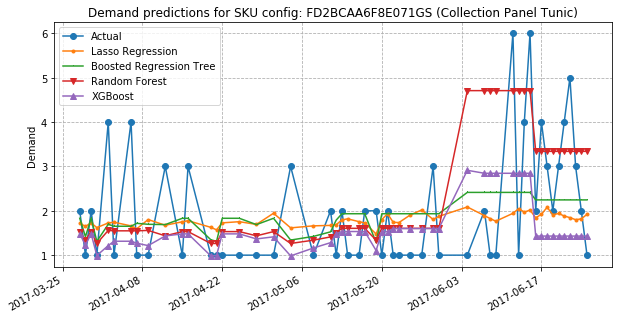


Samples of prediction:


,sku_config,product_name,brand_name,date,current_price,discount_from_rrp,n_competitor,rel_price,color_pop,brand_pop,...,predict_random_forest,predict_xgboost,diff_lasso_regression,abs_diff_lasso_regression,diff_boosted_regression_tree,abs_diff_boosted_regression_tree,diff_random_forest,abs_diff_random_forest,diff_xgboost,abs_diff_xgboost
17564,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-06-12,9.9,66.889632,1011,0.177655,0.086276,131015.0,...,4.708672,2.845602,-4.057325,4.057325,-3.585576,3.585576,-1.291328,1.291328,-3.154398,3.154398
17895,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-06-15,9.9,66.889632,1157,0.184307,0.086276,144524.0,...,4.708672,2.845602,-3.984434,3.984434,-3.585576,3.585576,-1.291328,1.291328,-3.154398,3.154398
18796,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-06-22,9.9,66.889632,2043,0.000088,0.086276,113056.0,...,3.339878,1.430258,-3.154226,3.154226,-2.754469,2.754469,-1.660122,1.660122,-3.569742,3.569742
17780,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-06-14,9.9,66.889632,1121,0.182724,0.086276,136384.0,...,4.708672,2.845602,-2.028355,2.028355,-1.585576,1.585576,0.708672,0.708672,-1.154398,1.154398
10850,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-04-02,14.9,50.167224,888,0.285662,0.086276,90850.0,...,1.557737,1.215130,-2.274043,2.274043,-2.304313,2.304313,-2.442263,2.442263,-2.784870,2.784870
11443,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-04-06,14.9,50.167224,867,0.296357,0.086276,78492.0,...,1.548272,1.313683,-2.340724,2.340724,-2.348584,2.348584,-2.451728,2.451728,-2.686317,2.686317
18661,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-06-21,9.9,66.889632,2120,0.000088,0.086276,119861.0,...,3.339878,1.430258,-2.117508,2.117508,-1.754469,1.754469,-0.660122,0.660122,-2.569742,2.569742
18124,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-06-17,9.9,66.889632,2287,0.000086,0.086276,126936.0,...,3.339878,1.430258,-2.079334,2.079334,-1.754469,1.754469,-0.660122,0.660122,-2.569742,2.569742
12495,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-04-16,14.9,50.167224,917,0.286088,0.086276,100224.0,...,1.530846,1.479443,-1.223464,1.223464,-1.168912,1.168912,-1.469154,1.469154,-1.520557,1.520557
16554,FD2BCAA6F8E071GS,Collection Panel Tunic,ZALORA,2017-05-29,10.0,66.555184,932,0.200100,0.086276,105266.0,...,1.604540,1.599764,-1.196259,1.196259,-1.066310,1.066310,-1.395460,1.395460,-1.400236,1.400236


In [120]:
inspect_results(cf='FD2BCAA6F8E071GS')

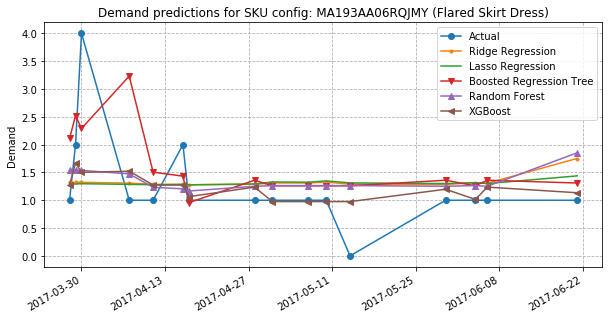


Samples of prediction:


,n_sold,predict_ridge_regression,predict_lasso_regression,predict_boosted_regression_tree,predict_random_forest,predict_xgboost
10368,4,1.321773,1.297121,2.290383,1.537178,1.501579
10208,2,1.320036,1.291499,2.519122,1.536722,1.669147
12486,2,1.285629,1.284360,1.433338,1.205358,1.274284
10026,1,1.325666,1.299463,2.112235,1.537659,1.273325
11561,1,1.308556,1.285515,3.231235,1.473354,1.522126
12061,1,1.284537,1.279019,1.504668,1.232543,1.274284
12590,1,1.278611,1.276968,0.957668,1.166325,1.064505
13531,1,1.286871,1.293301,1.359779,1.250577,1.236209
13806,1,1.310942,1.328907,1.259664,1.263579,0.976090
14296,1,1.309757,1.324677,1.259664,1.263579,0.976090


In [96]:
inspect_results(cf='MA193AA06RQJMY')

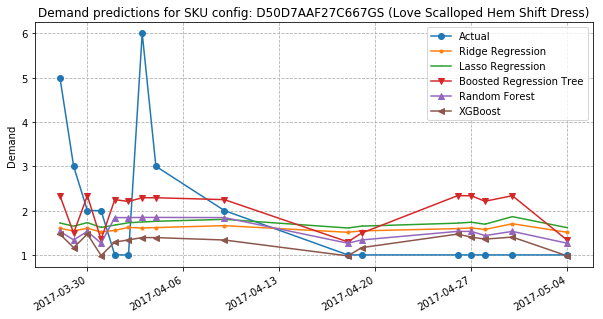


Samples of prediction:


,n_sold,predict_ridge_regression,predict_lasso_regression,predict_boosted_regression_tree,predict_random_forest,predict_xgboost
11068,6,1.607148,1.742667,2.289803,1.845940,1.390712
10114,5,1.597615,1.719811,2.336124,1.530846,1.469480
10296,3,1.542368,1.648539,1.492717,1.337587,1.163692
11214,3,1.617430,1.758622,2.289803,1.845940,1.390712
10458,2,1.601461,1.728762,2.336124,1.530846,1.469480
10604,2,1.516046,1.620190,1.349104,1.263579,0.986568
11859,2,1.660078,1.802419,2.247330,1.842131,1.335949
10745,1,1.553668,1.672016,2.247330,1.842131,1.289494
10908,1,1.619384,1.725957,2.206467,1.842131,1.338556
12710,1,1.510490,1.607100,1.294447,1.263579,0.977955


In [105]:
inspect_results(cf='D50D7AAF27C667GS')

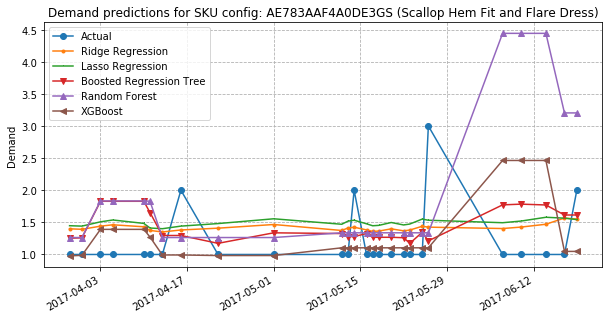


Samples of prediction:


,n_sold,predict_ridge_regression,predict_lasso_regression,predict_boosted_regression_tree,predict_random_forest,predict_xgboost
16314,3,1.425365,1.532752,1.211397,1.337273,1.103695
18383,2,1.550177,1.543166,1.614357,3.202944,1.047762
12493,2,1.381284,1.441252,1.295225,1.263579,0.991987
14948,2,1.424011,1.533092,1.278720,1.337273,1.103695
15304,1,1.358568,1.446782,1.267413,1.337273,1.103695
18123,1,1.567343,1.565056,1.614357,3.202944,1.047762
17778,1,1.470401,1.579010,1.770311,4.441405,2.463106
17372,1,1.426529,1.520105,1.783249,4.441405,2.463106
17093,1,1.403649,1.494146,1.771942,4.441405,2.463106
16182,1,1.438887,1.550580,1.344130,1.337273,1.103695


In [107]:
inspect_results(cf='AE783AAF4A0DE3GS')

## Female tops

### Train & Predict

In [19]:
rmse_df, predictions = benchmark(models, feats, group='tops_female_autumn-winter')

Preparing data of group tops_female_autumn-winter...
	 dropped NA configs
Whole data spans from 2016-04-17 to 2017-06-27
Split training and test sets by date 2017-03-30 00:00:00

 # records in training: 5376
Training data span ~11 months

# records in test: 4515
Test data span ~2 months
Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished


-0.02317318785
{'alpha': 10.0}
Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.7s finished


-0.0593721515334
{'max_depth': 7, 'n_estimators': 10}
Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   30.7s finished


-0.0840748128158
{'max_depth': 3, 'n_estimators': 10}
Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
-0.014746885358
{'max_depth': 5, 'n_estimators': 20}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   14.7s finished


### Group level evaluations

In [20]:
rmse_df

,model,test_rmse,train_rmse
0,Lasso Regression,0.791171,0.734089
2,Random Forest,0.818641,0.705663
3,XGBoost,0.853794,0.614396
1,Boosted Regression Tree,0.925981,0.574477


### Config level evaluations 

In [24]:
inspect_results(cf='MA193AA07ZKEMY')

IndexError: single positional indexer is out-of-bounds

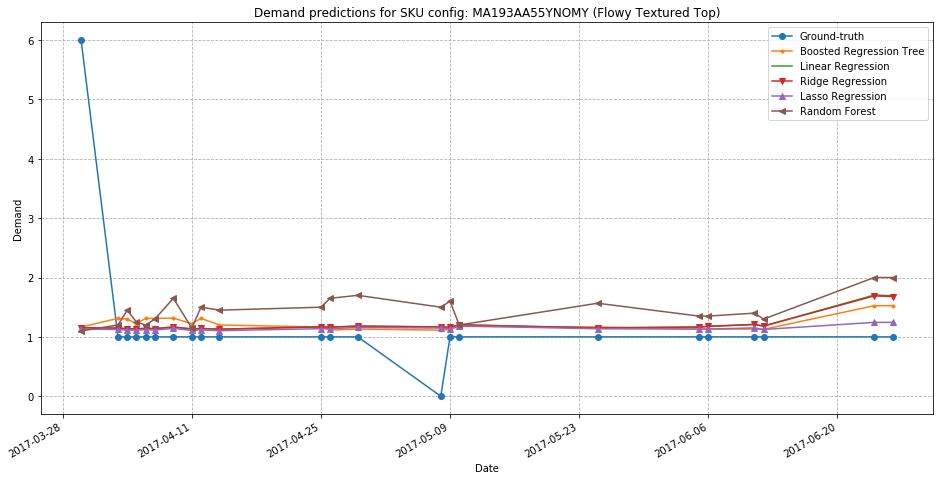

Samples of prediction:


,sku_config,product_name,brand_name,n_sold,predict_random_forest
5379,MA193AA55YNOMY,Flowy Textured Top,Mango,6,1.100000
5672,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.200000
5752,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.450000
5823,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.250000
5897,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.200000
5960,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.300000
6054,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.650000
6169,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.150000
6208,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.500000
6266,MA193AA55YNOMY,Flowy Textured Top,Mango,1,1.450000


In [107]:
inspect_results(cf='MA193AA55YNOMY')

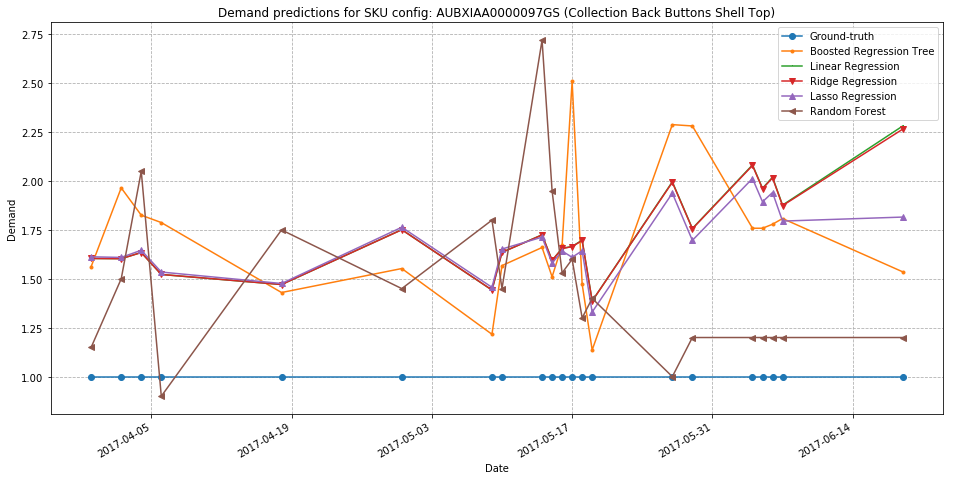

Samples of prediction:


,sku_config,product_name,brand_name,n_sold,predict_random_forest
5395,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,1.15
5602,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,1.50
5763,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,2.05
5913,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,0.90
6437,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,1.75
6870,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,1.45
7212,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,1.80
7243,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,1.45
7442,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,2.72
7509,AUBXIAA0000097GS,Collection Back Buttons Shell Top,ZALORA,1,1.95


In [108]:
inspect_results(cf='AUBXIAA0000097GS')

## Female jewellery

### Train & Predict

In [26]:
rmse_df, predictions = benchmark(models, feats, group='jewellery_female_autumn-winter')

Preparing data of group jewellery_female_autumn-winter...
	 dropped NA configs
Whole data spans from 2016-04-08 to 2017-06-27
Split training and test sets by date 2017-03-29 00:00:00

 # records in training: 313
Training data span ~11 months

# records in test: 221
Test data span ~2 months

Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
-0.422473609053
{'alpha': 1.0}

Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    2.4s finished


-0.829938879557
{'max_depth': 7, 'n_estimators': 10}

Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    8.2s finished


-0.516999899884
{'max_depth': 3, 'n_estimators': 30}

Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
-0.406235165314
{'max_depth': 3, 'n_estimators': 20}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.7s finished


### Group level evaluations

In [27]:
rmse_df

,model,test_rmse,train_rmse
3,XGBoost,0.458439,0.291902
2,Random Forest,0.463611,0.288379
0,Lasso Regression,0.494700,0.348712
1,Boosted Regression Tree,0.501126,0.194571


### Config level evaluations

# Spring-summer products

## Female heels

In [22]:
rmse_df, predictions = benchmark(models, feats, group='heels_female_spring-summer')

Preparing data of group heels_female_spring-summer...
	 dropped NA configs
Whole data spans from 2016-04-14 to 2017-06-27
Split training and test sets by date 2017-03-30 00:00:00

 # records in training: 784
Training data span ~11 months

# records in test: 5421
Test data span ~2 months

Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.00768802693311
{'alpha': 10.0}

Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.5s finished


-0.0721818483115
{'max_depth': 3, 'n_estimators': 10}

Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    9.8s finished


-0.0545557980257
{'max_depth': 3, 'n_estimators': 30}

Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
-0.0968113077014
{'max_depth': 3, 'n_estimators': 30}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished


## Male t-shirts

### Train & Predict

In [28]:
rmse_df, predictions = benchmark(models, feats, group='t-shirts_male_spring-summer')

Preparing data of group t-shirts_male_spring-summer...
	 dropped NA configs
Whole data spans from 2016-04-01 to 2017-06-27
Split training and test sets by date 2017-03-27 00:00:00

 # records in training: 2259
Training data span ~11 months

# records in test: 4282
Test data span ~3 months

Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
-0.103264348524
{'alpha': 10.0}

Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   10.8s finished


-0.0745877971924
{'max_depth': 3, 'n_estimators': 10}

Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   17.7s finished


-0.0735990881326
{'max_depth': 3, 'n_estimators': 90}

Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
-0.0571698747351
{'max_depth': 3, 'n_estimators': 20}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.8s finished


### Group level evals

In [29]:
rmse_df

,model,test_rmse,train_rmse
2,Random Forest,0.599778,0.491277
0,Lasso Regression,0.607320,0.521944
3,XGBoost,0.627093,0.491406
1,Boosted Regression Tree,0.633021,0.497984


### Config level evals

## Not enough data in spring-summer 2016
For groups/SKUs in season spring-summer, test data are much larger than training data!!! Because test data start in Apr and end in Jun of 2017, which is actually in season spring-summer2017, while training data start in later half of Apr-2016 and end in March-2017. Train data already include spring-summer of 2016, why so few data.